In [358]:
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import random

In [359]:
EPS = 1e-9

Параметр релаксации

In [360]:
omega = 1.5

Параметры сетки

In [361]:
Lx = np.pi / 2
Ly = np.pi / 2
n = 15
m = 15

Коэффициенты уравнения

In [362]:
a = 1
b = 0
c = 1
d = 2
e = 2
f = 4
g = 0

Коэффициенты в граничных условиях

In [363]:
alpha_0y = 0
beta_0y = 1

alpha_Ly = 0
beta_Ly = 1

alpha_x0 = 0
beta_x0 = 1

alpha_xL = 0
beta_xL = 1

Граничные условия

In [364]:
def gamma_0y(y):
    return np.exp(-y) * np.cos(y)


def gamma_Ly(y):
    return 0


def gamma_x0(x):
    return np.exp(-x) * np.cos(x)


def gamma_xL(x):
    return 0

Аналитическое решение   

In [365]:
def analytical(x, y):
    return np.exp(-x - y) * np.cos(x) * np.cos(y)

Шаги $h_x$ и $h_y$

In [366]:
hx = Lx / (n - 1)
hy = Ly / (m - 1)

hy2 = hy**2
hx2 = hx**2

In [367]:
x = [i * hx for i in range(n - 1)]
x.append(Lx)
x = np.array(x)

y = [j * hy for j in range(m - 1)]
y.append(Ly)
y = np.array(y)

In [368]:
bound_x0 = []
bound_xL = []

for i in range(n):
    bound_x0.append(gamma_x0(x[i]))
    bound_xL.append(gamma_xL(x[i]))

bound_0y = []
bound_Ly = []

for j in range(m):
    bound_0y.append(gamma_0y(y[j]))
    bound_Ly.append(gamma_Ly(y[j]))

In [369]:
x_plt, y_plt = np.meshgrid(x, y, indexing='ij')
true_data = analytical(x_plt, y_plt)

In [370]:
def get_delta(u, u_next):
    delta = -1
    for i in range(n):
        for j in range(m):
            delta = max(delta, abs(u[i][j] - u_next[i][j]))
    return delta

In [371]:
def get_boundary(u_next):
    for i in range(n):
        u_next[i][0] = 0
        u_next[i][m - 1] = 0
    
    for j in range(m):
        u_next[0][j] = 0
        u_next[n - 1][j] = 0
    

    for i in range(n):
        u_next[i][0] += (bound_x0[i] - alpha_x0 / hy * u_next[i][1]) / \
                        (beta_x0 - alpha_x0 / hy)

    for i in range(n):
        u_next[i][m - 1] += (bound_xL[i] - alpha_xL / hy * u_next[i][m - 2]) / \
                            (beta_xL - alpha_xL / hy)

    for j in range(m):
        u_next[0][j] += (bound_0y[j] - alpha_0y / hx * u_next[1][j]) / \
                        (beta_0y - alpha_0y / hx)
    
    for j in range(m):
        u_next[n - 1][j] += (bound_Ly[j] + alpha_Ly / hx * u_next[n - 2][j]) / \
                            (beta_Ly + alpha_Ly / hx)
    

    u_next[n - 1][m - 1] /= 2
    u_next[n - 1][0]     /= 2
    u_next[0][m - 1]     /= 2
    u_next[0][0]         /= 2

    return u_next


Метод Либмана

In [372]:
def liebmann_method():
    delta = 1
    iter_count = 0

    u = np.ones((n, m)) * 0.1

    while delta > EPS:
        u_next = np.zeros((n, m))

        for i in range(1, n - 1):
            for j in range(1, m - 1):
                u_next[i][j] = (c / hy2 - e / (2 * hy)) * u[i][j - 1] + \
                               (c / hy2 + e / (2 * hy)) * u[i][j + 1] + \
                               (a / hx2 - d / (2 * hx)) * u[i - 1][j] + \
                               (a / hx2 + d / (2 * hx)) * u[i + 1][j] + g
                u_next[i][j] /= (2 * (a / hx2 + c / hy2) - f)

        u_next = get_boundary(u_next)
        delta = get_delta(u, u_next)
        u = u_next
        iter_count += 1
    
    # print(f"Iteration counter: {iter_count}")
    return u

In [373]:
liebmann_data = liebmann_method().transpose()

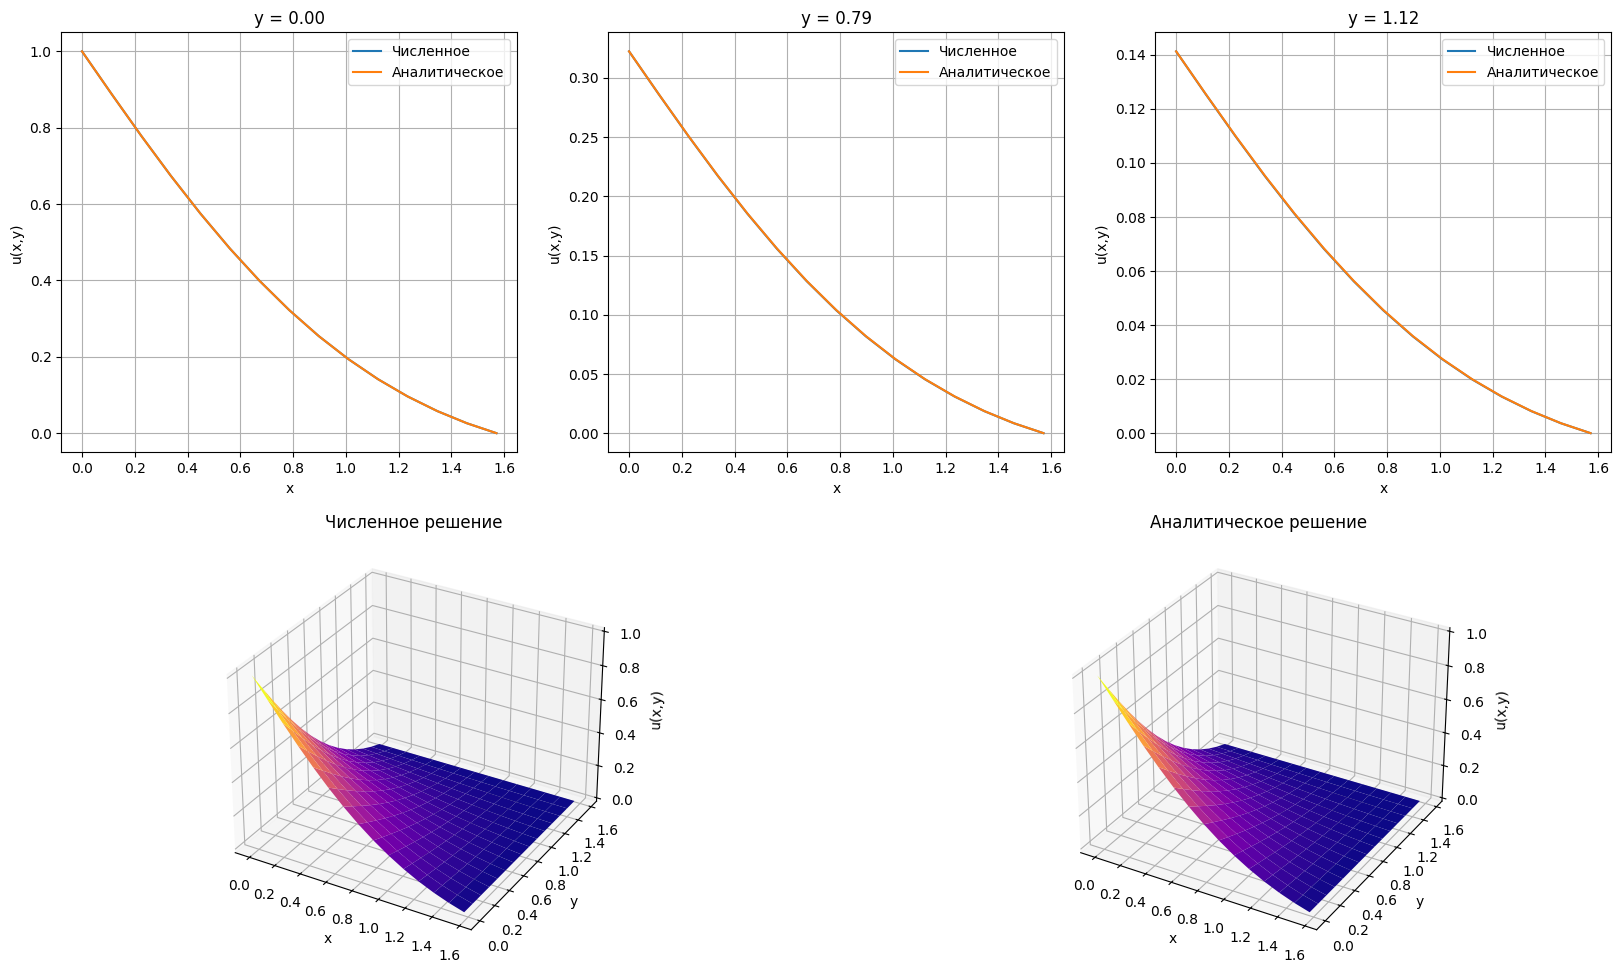

In [374]:
x_plt, y_plt = np.meshgrid(x, y)
true_data = analytical(x_plt, y_plt)

y_indices = random.sample(range(len(y) - 1), k=min(3, len(y)))
y_indices.sort()

fig = plt.figure(figsize=(20, 12))

for i, y_idx in enumerate(y_indices):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(x, liebmann_data[y_idx], label="Численное")
    ax.plot(x, true_data[y_idx], label="Аналитическое")
    ax.set_title(f"y = {y[y_idx]:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,y)')
    ax.legend()
    ax.grid(True)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
ax1.plot_surface(x_plt, y_plt, liebmann_data, cmap='plasma')
ax1.set_title('Численное решение')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
ax2.plot_surface(x_plt, y_plt, true_data, cmap='plasma')
ax2.set_title('Аналитическое решение')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

plt.show()

Метод Зейделя

In [375]:
def seidel_method():
    delta = 1
    iter_count = 0

    u = np.ones((n, m)) * 0.1

    while delta > EPS:
        u_next = u.copy()

        for i in range(1, n - 1):
            for j in range(1, m - 1):
                u_next[i][j] = (c / hy2 - e / (2 * hy)) * u_next[i][j - 1] + \
                               (c / hy2 + e / (2 * hy)) * u[i][j + 1] + \
                               (a / hx2 - d / (2 * hx)) * u_next[i - 1][j] + \
                               (a / hx2 + d / (2 * hx)) * u[i + 1][j] + g
                u_next[i][j] /= (2 * (a / hx2 + c / hy2) - f)

        u_next = get_boundary(u_next)
        delta = get_delta(u, u_next)
        u = u_next
        iter_count += 1

    # print(f"Iteration counter: {iter_count}")
    return u

In [376]:
seidel_data = seidel_method().transpose()

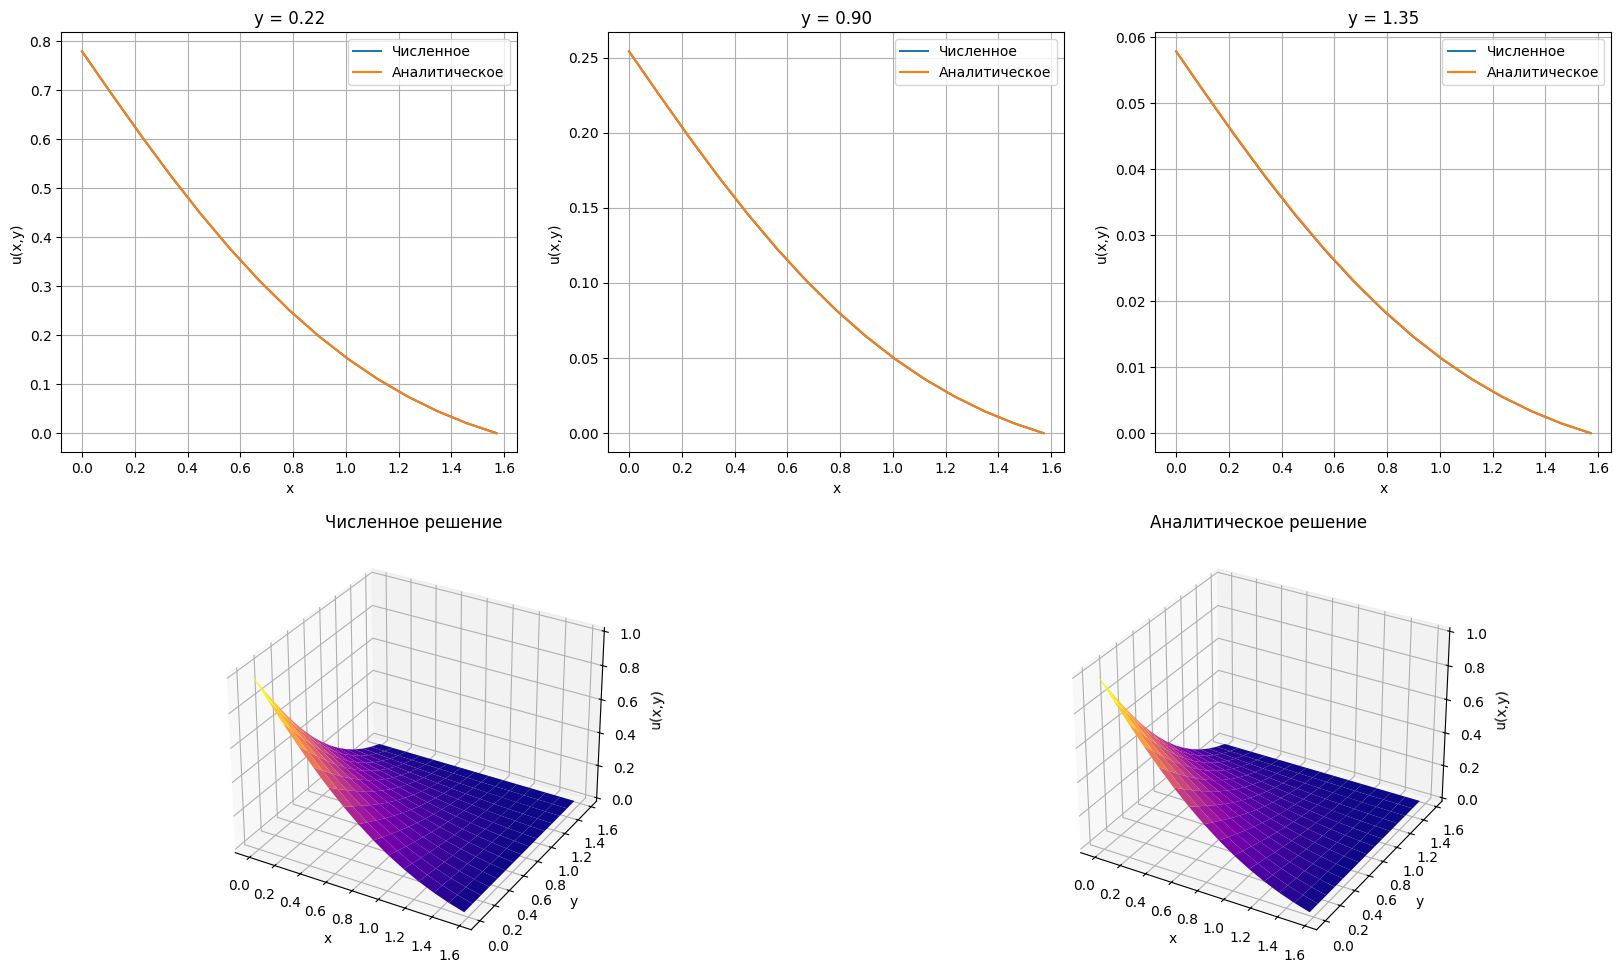

In [377]:
x_plt, y_plt = np.meshgrid(x, y)
true_data = analytical(x_plt, y_plt)

y_indices = random.sample(range(len(y) - 1), k=min(3, len(y)))
y_indices.sort()

fig = plt.figure(figsize=(20, 12))

for i, y_idx in enumerate(y_indices):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(x, seidel_data[y_idx], label="Численное")
    ax.plot(x, true_data[y_idx], label="Аналитическое")
    ax.set_title(f"y = {y[y_idx]:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,y)')
    ax.legend()
    ax.grid(True)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
ax1.plot_surface(x_plt, y_plt, seidel_data, cmap='plasma')
ax1.set_title('Численное решение')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
ax2.plot_surface(x_plt, y_plt, true_data, cmap='plasma')
ax2.set_title('Аналитическое решение')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

plt.show()

In [378]:
def relaxation_method():
    omega = 1.0038003800380038
    delta = 1
    iter_count = 0

    u = np.ones((n, m)) * 0.1

    while delta > EPS and iter_count < 1e3:
        u_next = np.zeros((n, m))

        for i in range(1, n - 1):
            for j in range(1, m - 1):
                u_next[i][j] = (c / hy2 - e / (2 * hy)) * u[i][j - 1] + \
                               (c / hy2 + e / (2 * hy)) * u[i][j + 1] + \
                               (a / hx2 - d / (2 * hx)) * u[i - 1][j] + \
                               (a / hx2 + d / (2 * hx)) * u[i + 1][j] + g
                u_next[i][j] /= (2 * (a / hx2 + c / hy2) - f)

        u_next = get_boundary(u_next)

        u_next = u_next * omega + (1 - omega) * u
        delta = get_delta(u, u_next)
        u = u_next
        iter_count += 1
    
    # print(f"Iteration counter: {iter_count}")
    return u

In [379]:
relaxation_data = relaxation_method().transpose()

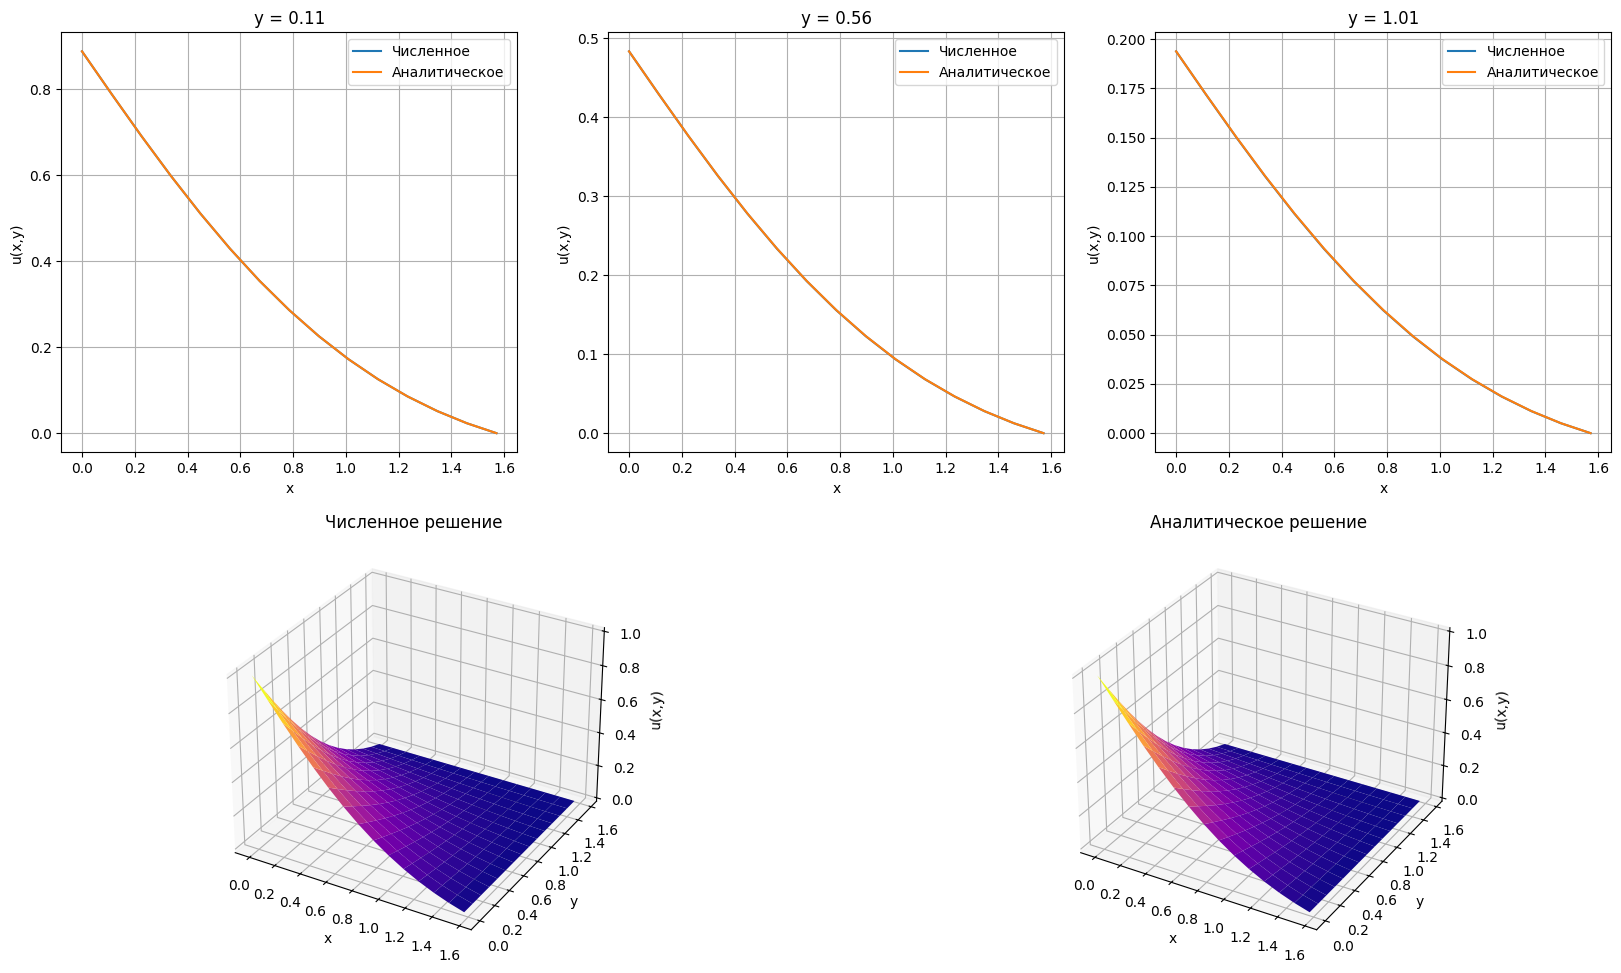

In [380]:
x_plt, y_plt = np.meshgrid(x, y)
true_data = analytical(x_plt, y_plt)

y_indices = random.sample(range(len(y) - 1), k=min(3, len(y)))
y_indices.sort()

fig = plt.figure(figsize=(20, 12))

for i, y_idx in enumerate(y_indices):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(x, relaxation_data[y_idx], label="Численное")
    ax.plot(x, true_data[y_idx], label="Аналитическое")
    ax.set_title(f"y = {y[y_idx]:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,y)')
    ax.legend()
    ax.grid(True)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
ax1.plot_surface(x_plt, y_plt, relaxation_data, cmap='plasma')
ax1.set_title('Численное решение')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
ax2.plot_surface(x_plt, y_plt, true_data, cmap='plasma')
ax2.set_title('Аналитическое решение')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

plt.show()

In [381]:
omega = 1.8
def seidel_relaxation_method():
    delta = 1
    iter_count = 0

    u = np.ones((n, m)) * 0.1

    while delta > EPS:
        u_next = u.copy()

        for i in range(1, n - 1):
            for j in range(1, m - 1):
                u_next[i][j] = (c / hy2 - e / (2 * hy)) * u_next[i][j - 1] + \
                               (c / hy2 + e / (2 * hy)) * u[i][j + 1] + \
                               (a / hx2 - d / (2 * hx)) * u_next[i - 1][j] + \
                               (a / hx2 + d / (2 * hx)) * u[i + 1][j] + g
                u_next[i][j] /= (2 * (a / hx2 + c / hy2) - f)
                u_next[i][j] = u_next[i][j] * omega + (1 - omega) * u[i][j]

        u_next = get_boundary(u_next)
        delta = get_delta(u, u_next)
        u = u_next
        iter_count += 1

    # print(f"Iteration counter: {iter_count}")
    return u

In [382]:
seidel_relaxation_data = seidel_relaxation_method().transpose()

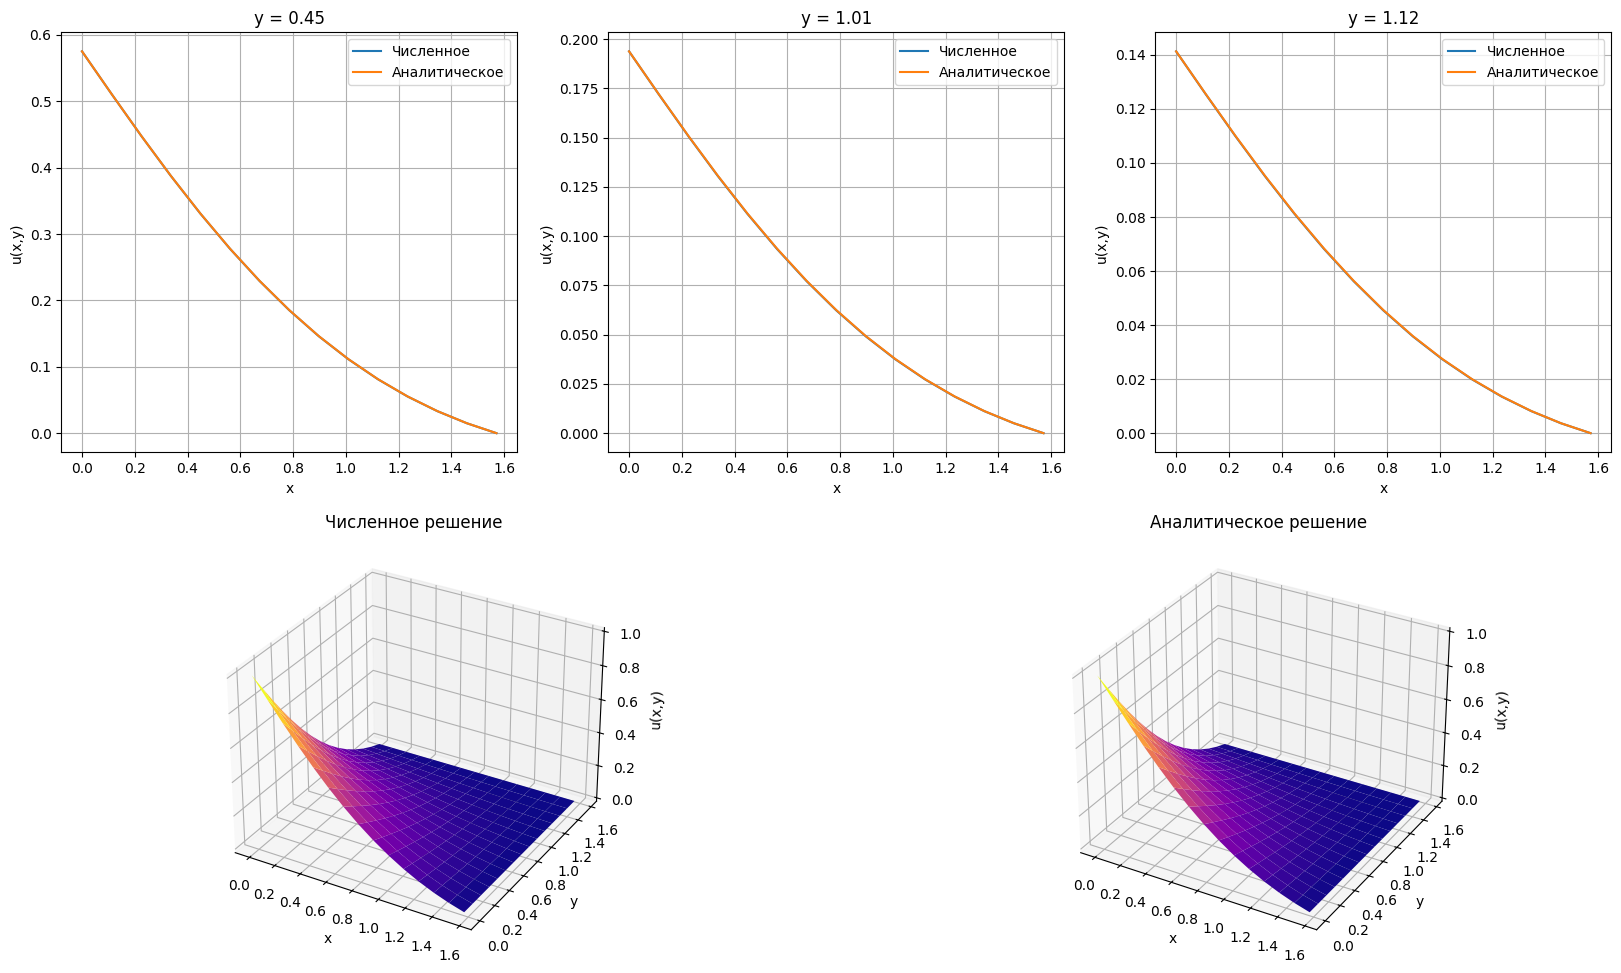

In [383]:
x_plt, y_plt = np.meshgrid(x, y)
true_data = analytical(x_plt, y_plt)

y_indices = random.sample(range(len(y) - 1), k=min(3, len(y)))
y_indices.sort()

fig = plt.figure(figsize=(20, 12))

for i, y_idx in enumerate(y_indices):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(x, seidel_relaxation_data[y_idx], label="Численное")
    ax.plot(x, true_data[y_idx], label="Аналитическое")
    ax.set_title(f"y = {y[y_idx]:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,y)')
    ax.legend()
    ax.grid(True)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
ax1.plot_surface(x_plt, y_plt, seidel_relaxation_data, cmap='plasma')
ax1.set_title('Численное решение')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
ax2.plot_surface(x_plt, y_plt, true_data, cmap='plasma')
ax2.set_title('Аналитическое решение')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

plt.show()

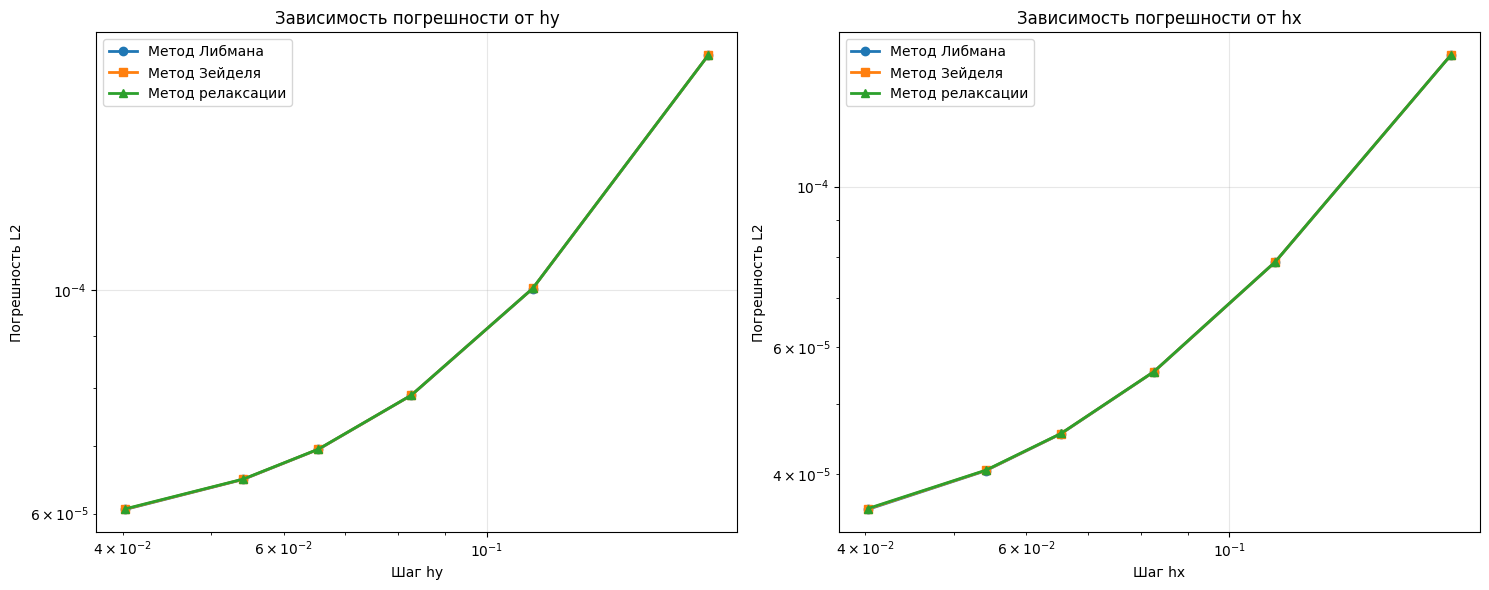

In [384]:
def compute_error(numerical_solution, analytical_solution):
    return np.sqrt(np.mean((numerical_solution - analytical_solution)**2))

fixed_n = 15
m_values = [10, 15, 20, 25, 30, 40]

errors_liebmann_hy = []
errors_seidel_hy = [] 
errors_relaxation_hy = []
hy_values = []


hx = Lx / (n - 1)
hy = Ly / (m - 1)

hy2 = hy**2
hx2 = hx**2

for m in m_values:
    n = fixed_n
    hy = (Ly - 0) / (m - 1)
    hx = (Lx - 0) / (n - 1)
    hx2 = hx * hx
    hy2 = hy * hy
    
    x = [i * hx for i in range(n - 1)]
    x.append(Lx)
    x = np.array(x)

    y = [j * hy for j in range(m - 1)]
    y.append(Ly)
    y = np.array(y)

    bound_x0 = []
    bound_xL = []

    for i in range(n):
        bound_x0.append(gamma_x0(x[i]))
        bound_xL.append(gamma_xL(x[i]))

    bound_0y = []
    bound_Ly = []

    for j in range(m):
        bound_0y.append(gamma_0y(y[j]))
        bound_Ly.append(gamma_Ly(y[j]))

    x_plt, y_plt = np.meshgrid(x, y, indexing='ij')
    true_data = analytical(x_plt, y_plt)
    
    liebmann_sol = liebmann_method()
    seidel_sol = seidel_method()
    relaxation_sol = seidel_relaxation_method()
    
    errors_liebmann_hy.append(compute_error(liebmann_sol, true_data))
    errors_seidel_hy.append(compute_error(seidel_sol, true_data))
    errors_relaxation_hy.append(compute_error(relaxation_sol, true_data))
    hy_values.append(hy)

fixed_m = 20
n_values = [10, 15, 20, 25, 30, 40]

errors_liebmann_hx = []
errors_seidel_hx = []
errors_relaxation_hx = [] 
hx_values = []

for n in n_values:
    m = fixed_m
    hy = (Ly - 0) / (m - 1)
    hx = (Lx - 0) / (n - 1)
    hx2 = hx * hx
    hy2 = hy * hy
    
    x = [i * hx for i in range(n - 1)]
    x.append(Lx)
    x = np.array(x)

    y = [j * hy for j in range(m - 1)]
    y.append(Ly)
    y = np.array(y)

    bound_x0 = []
    bound_xL = []

    for i in range(n):
        bound_x0.append(gamma_x0(x[i]))
        bound_xL.append(gamma_xL(x[i]))

    bound_0y = []
    bound_Ly = []

    for j in range(m):
        bound_0y.append(gamma_0y(y[j]))
        bound_Ly.append(gamma_Ly(y[j]))

    x_plt, y_plt = np.meshgrid(x, y, indexing='ij')
    true_data = analytical(x_plt, y_plt)
    
    liebmann_sol = liebmann_method()
    seidel_sol = seidel_method()
    relaxation_sol = seidel_relaxation_method()
    
    errors_liebmann_hx.append(compute_error(liebmann_sol, true_data))
    errors_seidel_hx.append(compute_error(seidel_sol, true_data))
    errors_relaxation_hx.append(compute_error(relaxation_sol, true_data))
    hx_values.append(hx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(hy_values, errors_liebmann_hy, 'o-', label='Метод Либмана', linewidth=2)
ax1.plot(hy_values, errors_seidel_hy, 's-', label='Метод Зейделя', linewidth=2)
ax1.plot(hy_values, errors_relaxation_hy, '^-', label='Метод релаксации', linewidth=2)
ax1.set_xlabel('Шаг hy')
ax1.set_ylabel('Погрешность L2')
ax1.set_title(f'Зависимость погрешности от hy')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(hx_values, errors_liebmann_hx, 'o-', label='Метод Либмана', linewidth=2)
ax2.plot(hx_values, errors_seidel_hx, 's-', label='Метод Зейделя', linewidth=2)
ax2.plot(hx_values, errors_relaxation_hx, '^-', label='Метод релаксации', linewidth=2)
ax2.set_xlabel('Шаг hx')
ax2.set_ylabel('Погрешность L2')
ax2.set_title(f'Зависимость погрешности от hx')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()